In [77]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Biotypes

Dataset rows are Gene Names, but need to identify the type of RNA transcripts: mRNA, miRNA, etc

Previously used API to access Ensembl database but many failed results, compare to directly using Ensembl website to get dataset of names and types

## Load Data

In [2]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)
data_FIB.head()

,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P23_S383,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
7SK,18,3,6,8,35,0,0,21,9,9,...,61,23,19,5,0,3,23,15,1,14
A4GALT,0,0,0,0,0,0,0,0,0,28,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,0,0,0,0,0,3,4,...,0,0,0,0,705,0,5,0,0,0
AACS,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,4,55,22,42
AADAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,270,0,0,0,0,0


## Old Biotypes

In [3]:
# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

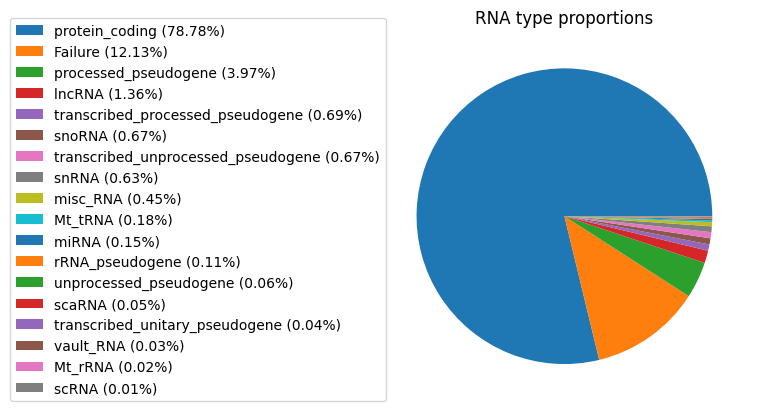

In [4]:
# display proportions of RNA types
types, counts = np.unique(biotypes, return_counts=True)
sort_idx = np.argsort(-counts)
types = types[sort_idx]
counts = counts[sort_idx]
plt.pie(counts)
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / len(biotypes), 2)}%)" for name, count in zip(types, counts)])
plt.title("RNA type proportions")
plt.show()

## New Biotypes

In [81]:
biotypes_new_df = pd.read_csv("./Biotypes/mart_export.txt")
biotypes_new_df.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene name,Transcript type,Gene type
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,MT-TF,Mt_tRNA,Mt_tRNA
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,MT-RNR1,Mt_rRNA,Mt_rRNA
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,MT-TV,Mt_tRNA,Mt_tRNA
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,MT-RNR2,Mt_rRNA,Mt_rRNA
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,MT-TL1,Mt_tRNA,Mt_tRNA


In [82]:
# drop ID info & only use gene type
biotypes_new_df = biotypes_new_df[['Gene name', 'Gene type']].drop_duplicates().dropna()
biotypes_new_df

,Gene name,Gene type
0,MT-TF,Mt_tRNA
1,MT-RNR1,Mt_rRNA
2,MT-TV,Mt_tRNA
3,MT-RNR2,Mt_rRNA
4,MT-TL1,Mt_tRNA
...,...,...
533440,TSPAN1,protein_coding
533467,AHCYL1,protein_coding
533480,JMJD4,protein_coding
533530,DAP3,protein_coding


In [93]:
# select data gene names
data_gene_names = data_FIB.index

# for each gene name
data_gene_types = []
for name in tqdm.tqdm(data_gene_names):

    # select all associated gene types
    gene_types = biotypes_new_df[biotypes_new_df['Gene name'] == name]['Gene type']

    # no data
    if len(gene_types) == 0:
        data_gene_types.append("Failure")

    # unique type: add
    elif len(gene_types) == 1:
        data_gene_types.append(gene_types.iloc[0])

    # multiple types
    # choose protein coding first
    elif "protein_coding" in gene_types:
        data_gene_types.append("protein_coding")
    # then choose majority
    else:
        #data_gene_types.append("Ambiguous")
        data_gene_types.append(gene_types.value_counts().index[0])

100%|██████████| 11901/11901 [01:14<00:00, 159.51it/s]


In [98]:
# select data gene names
data_gene_names = data_FIB.index

# for each gene name
data_gene_types_ambiguous = []
for name in tqdm.tqdm(data_gene_names):

    # select all associated gene types
    gene_types = biotypes_new_df[biotypes_new_df['Gene name'] == name]['Gene type']

    # no data
    if len(gene_types) == 0:
        data_gene_types_ambiguous.append("Failure")

    # unique type: add
    elif len(gene_types) == 1:
        data_gene_types_ambiguous.append(gene_types.iloc[0])

    # multiple types
    # choose protein coding first
    elif "protein_coding" in gene_types:
        data_gene_types_ambiguous.append("protein_coding")
    # then choose majority
    else:
        data_gene_types_ambiguous.append("Ambiguous")
        #data_gene_types.append(gene_types.value_counts().index[0])

100%|██████████| 11901/11901 [00:56<00:00, 209.76it/s]


In [ ]:
# Recommended:
# Use gene types
# If ambiguous set as protein coding if present
# Otherwise set as ambiguous

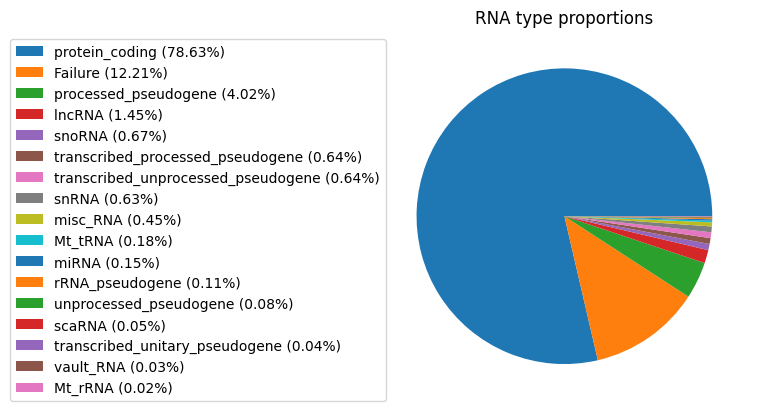

In [97]:
# display proportions of RNA types
types, counts = np.unique(data_gene_types, return_counts=True)
sort_idx = np.argsort(-counts)
types = types[sort_idx]
counts = counts[sort_idx]
plt.pie(counts)
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(types, counts)])
plt.title("RNA type proportions")
plt.show()

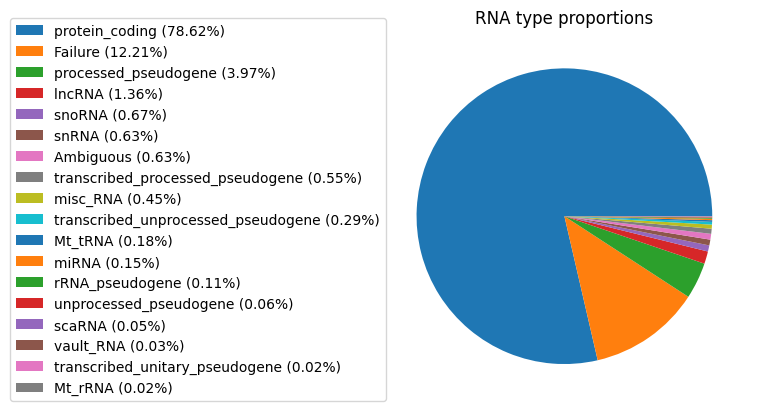

In [99]:
# display proportions of RNA types
types, counts = np.unique(data_gene_types_ambiguous, return_counts=True)
sort_idx = np.argsort(-counts)
types = types[sort_idx]
counts = counts[sort_idx]
plt.pie(counts)
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(types, counts)])
plt.title("RNA type proportions")
plt.show()

## Alignment

In [113]:
mask_aligned = (np.array(biotypes) == np.array(data_gene_types))
print(f"{sum(mask_aligned)} out of {len(mask_aligned)} matching biotypes between new and old method")

11870 out of 11901 matching biotypes between new and old method


In [114]:
for type_1, type_2 in zip(np.array(biotypes)[~mask_aligned], np.array(data_gene_types)[~mask_aligned]):
    print(f"{type_1} | {type_2}")

protein_coding | Failure
scRNA | lncRNA
protein_coding | Failure
protein_coding | Failure
protein_coding | Failure
protein_coding | Failure
protein_coding | Failure
protein_coding | lncRNA
protein_coding | lncRNA
protein_coding | Failure
protein_coding | Failure
protein_coding | lncRNA
transcribed_processed_pseudogene | processed_pseudogene
Failure | lncRNA
transcribed_unprocessed_pseudogene | lncRNA
transcribed_unprocessed_pseudogene | unprocessed_pseudogene
transcribed_processed_pseudogene | processed_pseudogene
protein_coding | lncRNA
transcribed_processed_pseudogene | processed_pseudogene
protein_coding | Failure
protein_coding | lncRNA
transcribed_processed_pseudogene | processed_pseudogene
protein_coding | processed_pseudogene
protein_coding | lncRNA
processed_pseudogene | lncRNA
protein_coding | Failure
transcribed_processed_pseudogene | processed_pseudogene
transcribed_processed_pseudogene | processed_pseudogene
protein_coding | Failure
transcribed_unprocessed_pseudogene | unpr

# Conclusion

Overall very close match between new and existing biotypes, with only small number (31) of genes differing. None of these differences include miRNA, and existing biotypes include slightly more protein coding genes which will just be included in tests.

Keep using existing biotypes, can be confident in correctness.

NOTE: for new datasets use new method of ensembl biomart download, as much faster than using python API package:

https://useast.ensembl.org/info/data/biomart/how_to_use_biomart.html#introduction